# import các thư viện cần thiết

In [31]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
# import seaborn as sns
# sns.set_style('darkgrid')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [32]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Thiết lập memory growth cho từng GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
        print("Memory growth has been set for GPUs.")
    except RuntimeError as e:
        # Memory growth phải được thiết lập trước khi các GPU được sử dụng
        print(e)

Memory growth has been set for GPUs.


# I. Tiền xử lý dữ liệu: 

In [33]:
# Tạo dataFrame chứa tên thư mục của ảnh và mask của ảnh tương ứng
def create_df(data_dir):
    images_path = []
    mask_paths = glob(f'{data_dir}/*/*_mask*')          # liệt kê tất cả các file có /*/*_mask* 
                                                        # vd: ("../TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1"_mask".tif")
    for i in mask_paths:
        images_path.append(i.replace('_mask', ''))      # với mỗi mask_path thì image_path sẽ có 1 ảnh tương ứng với đường dẫn không có "_mask"
                                                        # vd: ("../TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif")
    df = pd.DataFrame(data={'images': images_path, 'masks': mask_paths})
    return df

data_dir = '/home/anhhao/learn/ComputerVision/CK_segmentation/Unet_BrainTumor_Segmentaion/dataTCGA/kaggle_3m'
df = create_df(data_dir)
df.tail(3)

images  \
3926  /home/anhhao/learn/ComputerVision/CK_segmentat...   
3927  /home/anhhao/learn/ComputerVision/CK_segmentat...   
3928  /home/anhhao/learn/ComputerVision/CK_segmentat...   

                                                  masks  
3926  /home/anhhao/learn/ComputerVision/CK_segmentat...  
3927  /home/anhhao/learn/ComputerVision/CK_segmentat...  
3928  /home/anhhao/learn/ComputerVision/CK_segmentat...

3929 ảnh và 3929 mask

In [34]:
image = cv2.imread(df["images"][0], cv2.IMREAD_UNCHANGED)
image.shape

(256, 256, 3)

In [35]:
print(len(df["images"]))
print(len(df["masks"]))

3929
3929


**Hiển thị 1 vài ảnh trong dataset**

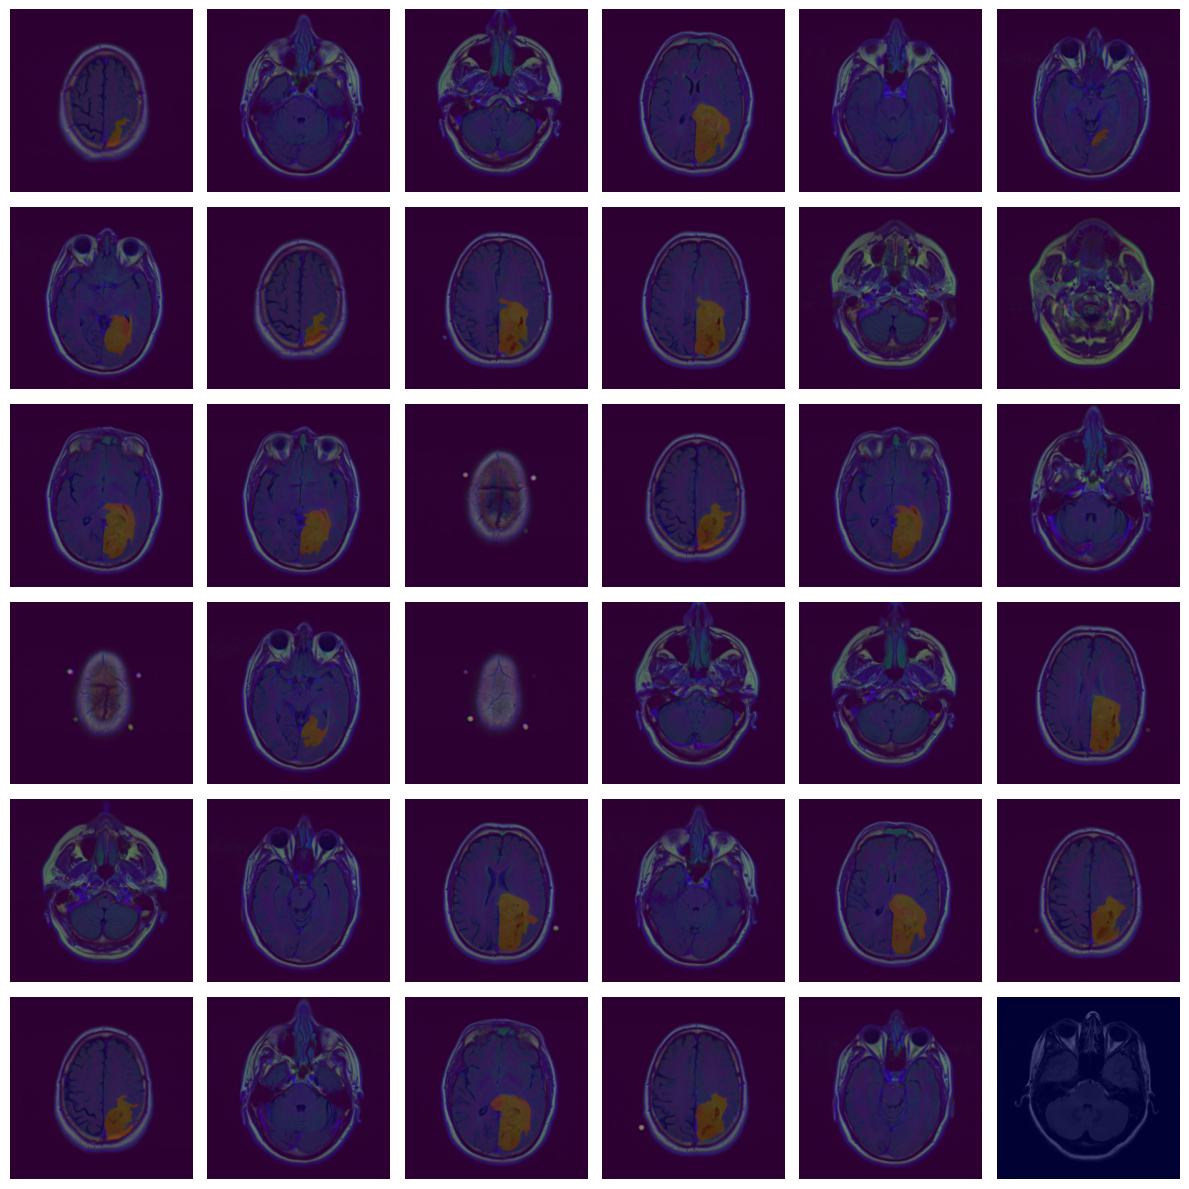

In [22]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    
    for i in range(36):
        plt.subplot(6, 6, i + 1)

        img_path = images[i + 16]
        mask_path = masks[i + 16]

        # Read image
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) # Giữ nguyên depth
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)     # Convert image to RGB

        # Read the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 

        # Display the image
        plt.imshow(image)
        plt.imshow(mask, cmap="jet", alpha=0.4) 
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_images(list(df["images"]), list(df["masks"]))

**Chia tập dữ liệu**

In [36]:
# split dataset
def split_df(df):
    train_df, temp_df = train_test_split(df, train_size=0.8)      # 80% dữ liệu train
    
    valid_df, test_df = train_test_split(temp_df, train_size=0.5) # 10% valid, 10% test
    
    return train_df, valid_df, test_df

train_dir, valid_dir, test_dir = split_df(df)

In [37]:
print("Train data: ", len(train_dir))
print("Valid data: ", len(valid_dir))
print("Test data: ", len(test_dir))
print("Total data: ", len(df))

Train data:  3143
Valid data:  393
Test data:  393
Total data:  3929


**Tăng cường dữ liệu ảnh (data augmentation)**

In [38]:
# định nghĩa hàm 
def create_gens(df, aug_dict):
    img_size = (256, 256)
    batch_size = 8


    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    image_gen = img_gen.flow_from_dataframe(df, 
                                            x_col='images', 
                                            class_mode=None, 
                                            color_mode='rgb', 
                                            target_size=img_size,
                                            batch_size=batch_size, 
                                            save_to_dir="/home/anhhao/learn/ComputerVision/CK_segmentation/Unet_BrainTumor_Segmentaion/output/augmentation", 
                                            save_prefix='image', 
                                            seed=36)

    mask_gen = msk_gen.flow_from_dataframe(df, 
                                            x_col='masks', 
                                            class_mode=None, 
                                            color_mode='grayscale', 
                                            target_size=img_size, 
                                            batch_size=batch_size, 
                                            save_to_dir="/home/anhhao/learn/ComputerVision/CK_segmentation/Unet_BrainTumor_Segmentaion/output/augmentation", 
                                            save_prefix= 'mask', 
                                            seed=36) 

    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:
        img = img / 255.
        msk = msk / 255.
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0

        yield (img, msk)
        

# 
tr_aug_dict = dict( rotation_range=0.2,         # xoay ảnh 20% [-72 độ ~ 72 độ ] (0.2 * 360 độ)
                    width_shift_range=0.05,     # dịch chuyển 5% chiều ngang của ảnh
                    height_shift_range=0.05,    # dịch chuyển 5% chiều dọc của ảnh
                    shear_range=0.05,           # làm méo ảnh 5%
                    zoom_range=0.05,            # phóng to/thu nhỏ ảnh 5%
                    horizontal_flip=True,       # lật ảnh theo chiều ngang
                    fill_mode='nearest')        # xử lý các pixel mới khi có sự thay đổi bằng các giá trị pixel gần nhất


train_gen = create_gens(train_dir, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_dir, aug_dict={})
test_gen = create_gens(test_dir, aug_dict={})

# II. Xây dựng mô hình Unet:

In [39]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [8]:
def unet(input_size=(256, 256, 3)):
    ### Build the model 
    inputs = layers.Input(input_size)
    
    ### inputs is the image we want to segment  
    ### c1 is the first 'block' of the architechture
    ### p1 is maxpooling of (c1) and the input of c2

    # Encoder (Downsampling Path)
    ### first 'block'
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)  ## input_shape = (256, 256, 3)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)   ## c1.shape = (256, 256, 64)
    c1 = layers.BatchNormalization(axis=3)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)        ## shape (128, 128, 64)

    ### seccond 'block'
    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)   ## c2.shape = (128, 128, 128)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)   ## c2.shape = (128, 128, 128)
    c2 = layers.BatchNormalization(axis=3)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)        ## shape (64, 64, 128)

    ### third 'block'
    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)   ## c3.shape = (64, 64, 256)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)   ## c3.shape = (64, 64, 256)
    c3 = layers.BatchNormalization(axis=3)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)        ## shape (32, 32, 256)

    ### fourth 'block'
    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)  ## c4.shape = (32, 32, 512)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)  ## c4.shape = (32, 32, 512)
    c4 = layers.BatchNormalization(axis=3)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)        ## shape (16, 16, 512)

    ### fifth 'block'   we don't have 'p' in fifth block
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.BatchNormalization(axis=3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)  ## c5.shape = (16, 16, 1024)
    
    
    # Decoder (Upsampling Path)
    ### 
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)    ## u6.shape = (32, 32, 512)
    u6 = layers.concatenate([u6, c4])   ## u6.shape = (32, 32, 1024)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)  ## c6.shape = (32, 32, 512)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.BatchNormalization(axis=3)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)  ## c6.shape = (32, 32, 512)

    ### 
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)     ## u7.shape = (64, 64, 256)
    u7 = layers.concatenate([u7, c3])   ## u7.shape = (64, 64, 512)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)   ## c7.shape = (64, 64, 256)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.BatchNormalization(axis=3)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)   ## c7.shape = (64, 64, 256)

    ### 
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)     ## u8.shape = (128, 128, 128)
    u8 = layers.concatenate([u8, c2])   ## u8.shape = (64, 64, 256)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)   ## c8.shape = (128, 128, 128)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.BatchNormalization(axis=3)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)   ## c8.shape = (128, 128, 128)

    ### 
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)     ## u9.shape = (256, 256, 64)
    u9 = layers.concatenate([u9, c1])   ## u9.shape = (256, 256, 128)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)   ## c9.shape = (256, 256, 64)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.BatchNormalization(axis=3)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)   ## c9.shape = (256, 256, 64)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)    ## outputs.shape = (256, 256, 1)
    
    model = Model(inputs, outputs)
    return model

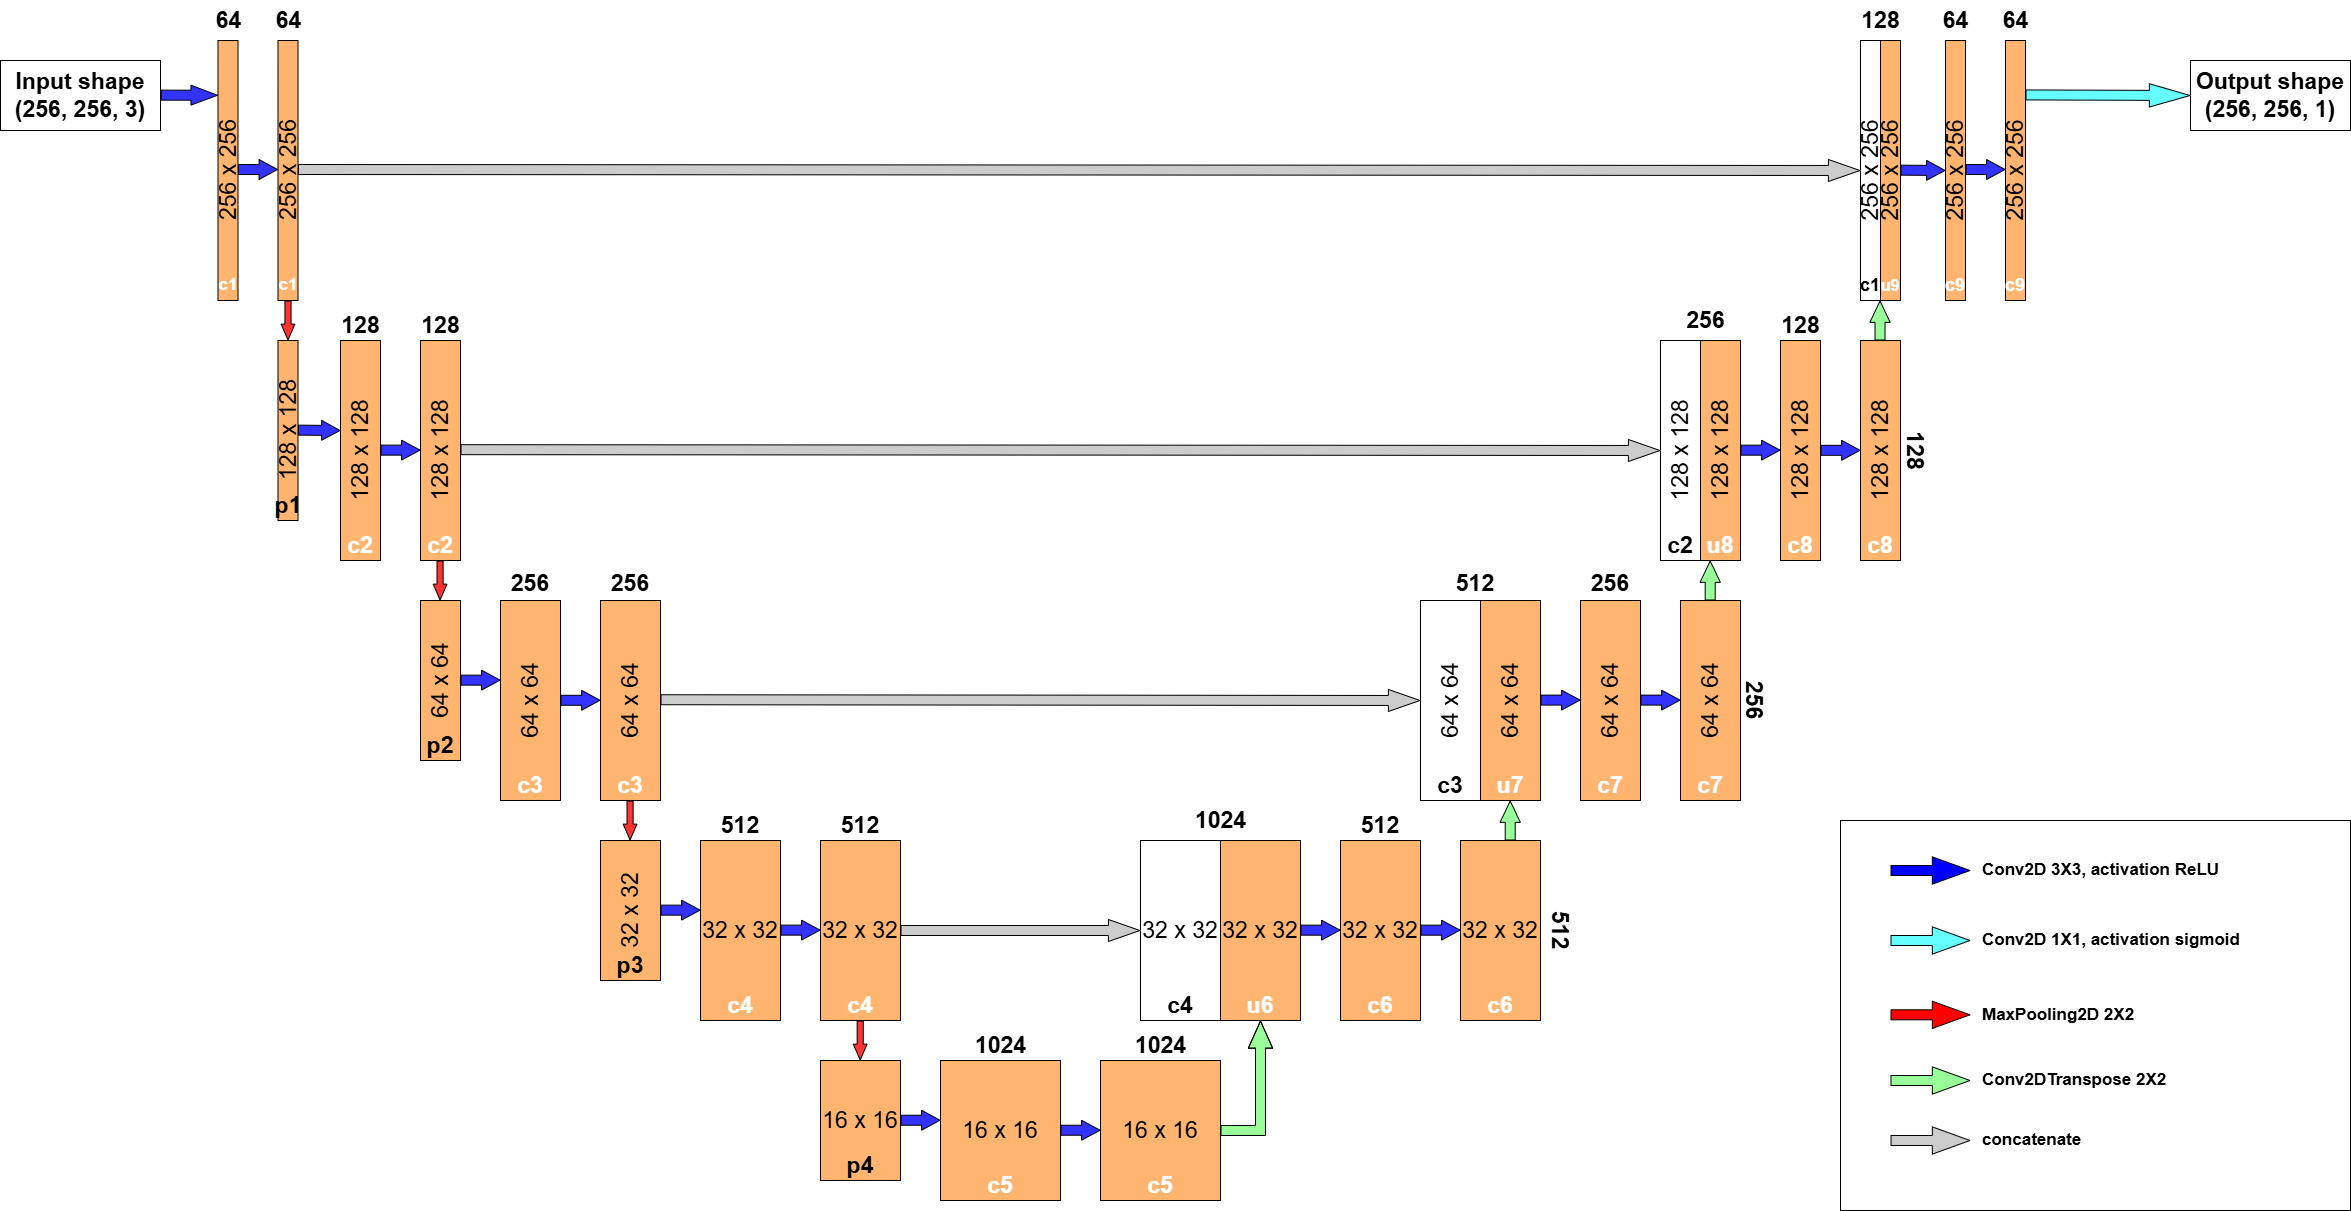

# Độ đo và hàm mất mát (metrics and loss function)

### 1. Dice coefficient (F1 Score)

**Dice coefficient** được tính theo công thức sau:

$$
\text{Dice}(A, B) = \frac{2 \cdot |A \cap B|}{|A| + |B|}
$$

**Trong đó:**
$${( A )} \text{ là tập hợp các pixel trong mặt nạ thực tế (ground truth).}$$
$${( B )} \text{ là tập hợp các pixel trong mặt nạ dự đoán (prediction).}$$
$${{|A| + |B|}} \text{ là số lượng pixel trong mặt nạ thực tế và mặt nạ dự đoán, tương ứng.}$$
$${|A \cap B|} \text{ là số lượng pixel chung giữa mặt nạ thực tế và mặt nạ dự đoán.}$$


In [45]:
# định nghĩa hàm tính "dice coefficient"
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = backend.flatten(y_true)
    y_pred_flatten = backend.flatten(y_pred)

    intersection = backend.sum(y_true_flatten * y_pred_flatten)
    union = backend.sum(y_true_flatten) + backend.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

### 2. Dice Loss



**Dice Loss** được tính theo công thức sau:

$$
\text{Dice Loss} = 1 - \frac{2 \cdot \sum_{i} (y_i \cdot \hat{y}_i)}{\sum_{i} y_i + \sum_{i} \hat{y}_i}
$$

**Trong đó:**

 $${y_i} \text{ là giá trị của pixel tại vị trí \( i \) trong mặt nạ thực tế (ground truth).}$$
 $${\hat{y}_i} \text{ là giá trị của pixel tại vị trí \( i \) trong mặt nạ dự đoán (prediction).}$$
 $${\sum_{i} (y_i \cdot \hat{y}_i)}\text{ là tổng hợp các pixel trùng khớp giữa mặt nạ thực tế và mặt nạ dự đoán.}$$
 $${\sum_{i} y_i} \text{ và } {( \sum_{i} \hat{y}_i)} \text{ là tổng số pixel trong mặt nạ thực tế và mặt nạ dự đoán, lần lượt.}$$


In [41]:
# Định nghĩa hàm tính "dice loss"
def dice_loss(y_true, y_pred, smooth=100):
    return 1-dice_coef(y_true, y_pred, smooth)

### 3. IoU (Intersection over Union)

**IoU** được tính theo công thức sau:

$$
\text{IoU}(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

**Trong đó:**

 $${( A )} \text{ là tập các pixel thuộc đối tượng trong mặt nạ thực tế (ground truth).}$$
 $${( B )} \text{ là tập các pixel thuộc đối tượng trong mặt nạ dự đoán (prediction).}$$
 $${( |A \cap B| )} \text{ là số pixel chung giữa mặt nạ thực tế và mặt nạ dự đoán (giao nhau).}$$
 $${( |A \cup B| )} \text{ là tổng số pixel thuộc ít nhất một trong hai mặt nạ (hợp lại).}$$


In [42]:
# Định nghĩa hàm tính "iou coefficient"
def iou_coef(y_true, y_pred, smooth=100):
    intersection = backend.sum(y_true * y_pred)
    sum = backend.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

### Adamax Optimizer

Adamax là một biến thể của Adam, sử dụng chuẩn vô hạn $$( L_\infty )$$ để tính toán bước cập nhật.


**Các bước của Adamax như sau:**

1. Tính các giá trị trung bình động:

$$
m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t
$$

$$
u_t = \max(\beta_2 \cdot u_{t-1}, |g_t|)
$$

2. Hiệu chỉnh thiên lệch cho \( m_t \):

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$$

3. Cập nhật tham số:

$$
\theta_t = \theta_{t-1} - \eta \cdot \frac{\hat{m}_t}{u_t}
$$

**Trong đó:**

 $${( g_t )}\text{: gradient tại thời điểm }{( t )}$$
 $${( m_t )}\text{: trung bình động của gradient } {(momentum)}$$
 $${ ( u_t )}\text{: chuẩn vô hạn của gradient tích lũy}$$
 $${( \beta_1, \beta_2 )}\text{: hệ số momentum (thường là 0.9 và 0.999)}$$
 $${( \eta )}\text{: learning rate}
 $${( \theta_t )}\text{: tham số mô hình tại thời điểm}{( t )}


In [12]:
model = unet(input_size=(256, 256, 3))
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])
model.summary()

I0000 00:00:1744606922.755499    1753 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

# III. Huấn luyện mô hình:

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
callbacks = [
    ModelCheckpoint('/home/anhhao/learn/ComputerVision/CK_segmentation/Unet_BrainTumor_Segmentaion/model_saved/model_UnetTCGA_v5_125-epochs.keras', 
                    monitor='val_iou_coef', 
                    verbose=1, save_best_only=True, 
                    mode='max'),
    TensorBoard(log_dir="/home/anhhao/learn/ComputerVision/CK_segmentation/output/logs_v3")
]

history = model.fit(train_gen, 
                    validation_data=valid_gen,
                    steps_per_epoch=len(train_dir) // 8,
                    epochs=225, 
                    callbacks=callbacks,
                    validation_steps=len(valid_dir) // 8)

In [ ]:
from tensorflow.keras.models import save_model

save_model(model, "/home/anhhao/learn/ComputerVision/CK_segmentation/Unet_BrainTumor_Segmentaion/model_saved/last_model_Unet_TCGA.keras")

# IV. Đánh giá mô hình:

In [51]:
def plot_training(hist):
    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(iou_coef)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(dice_coef)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

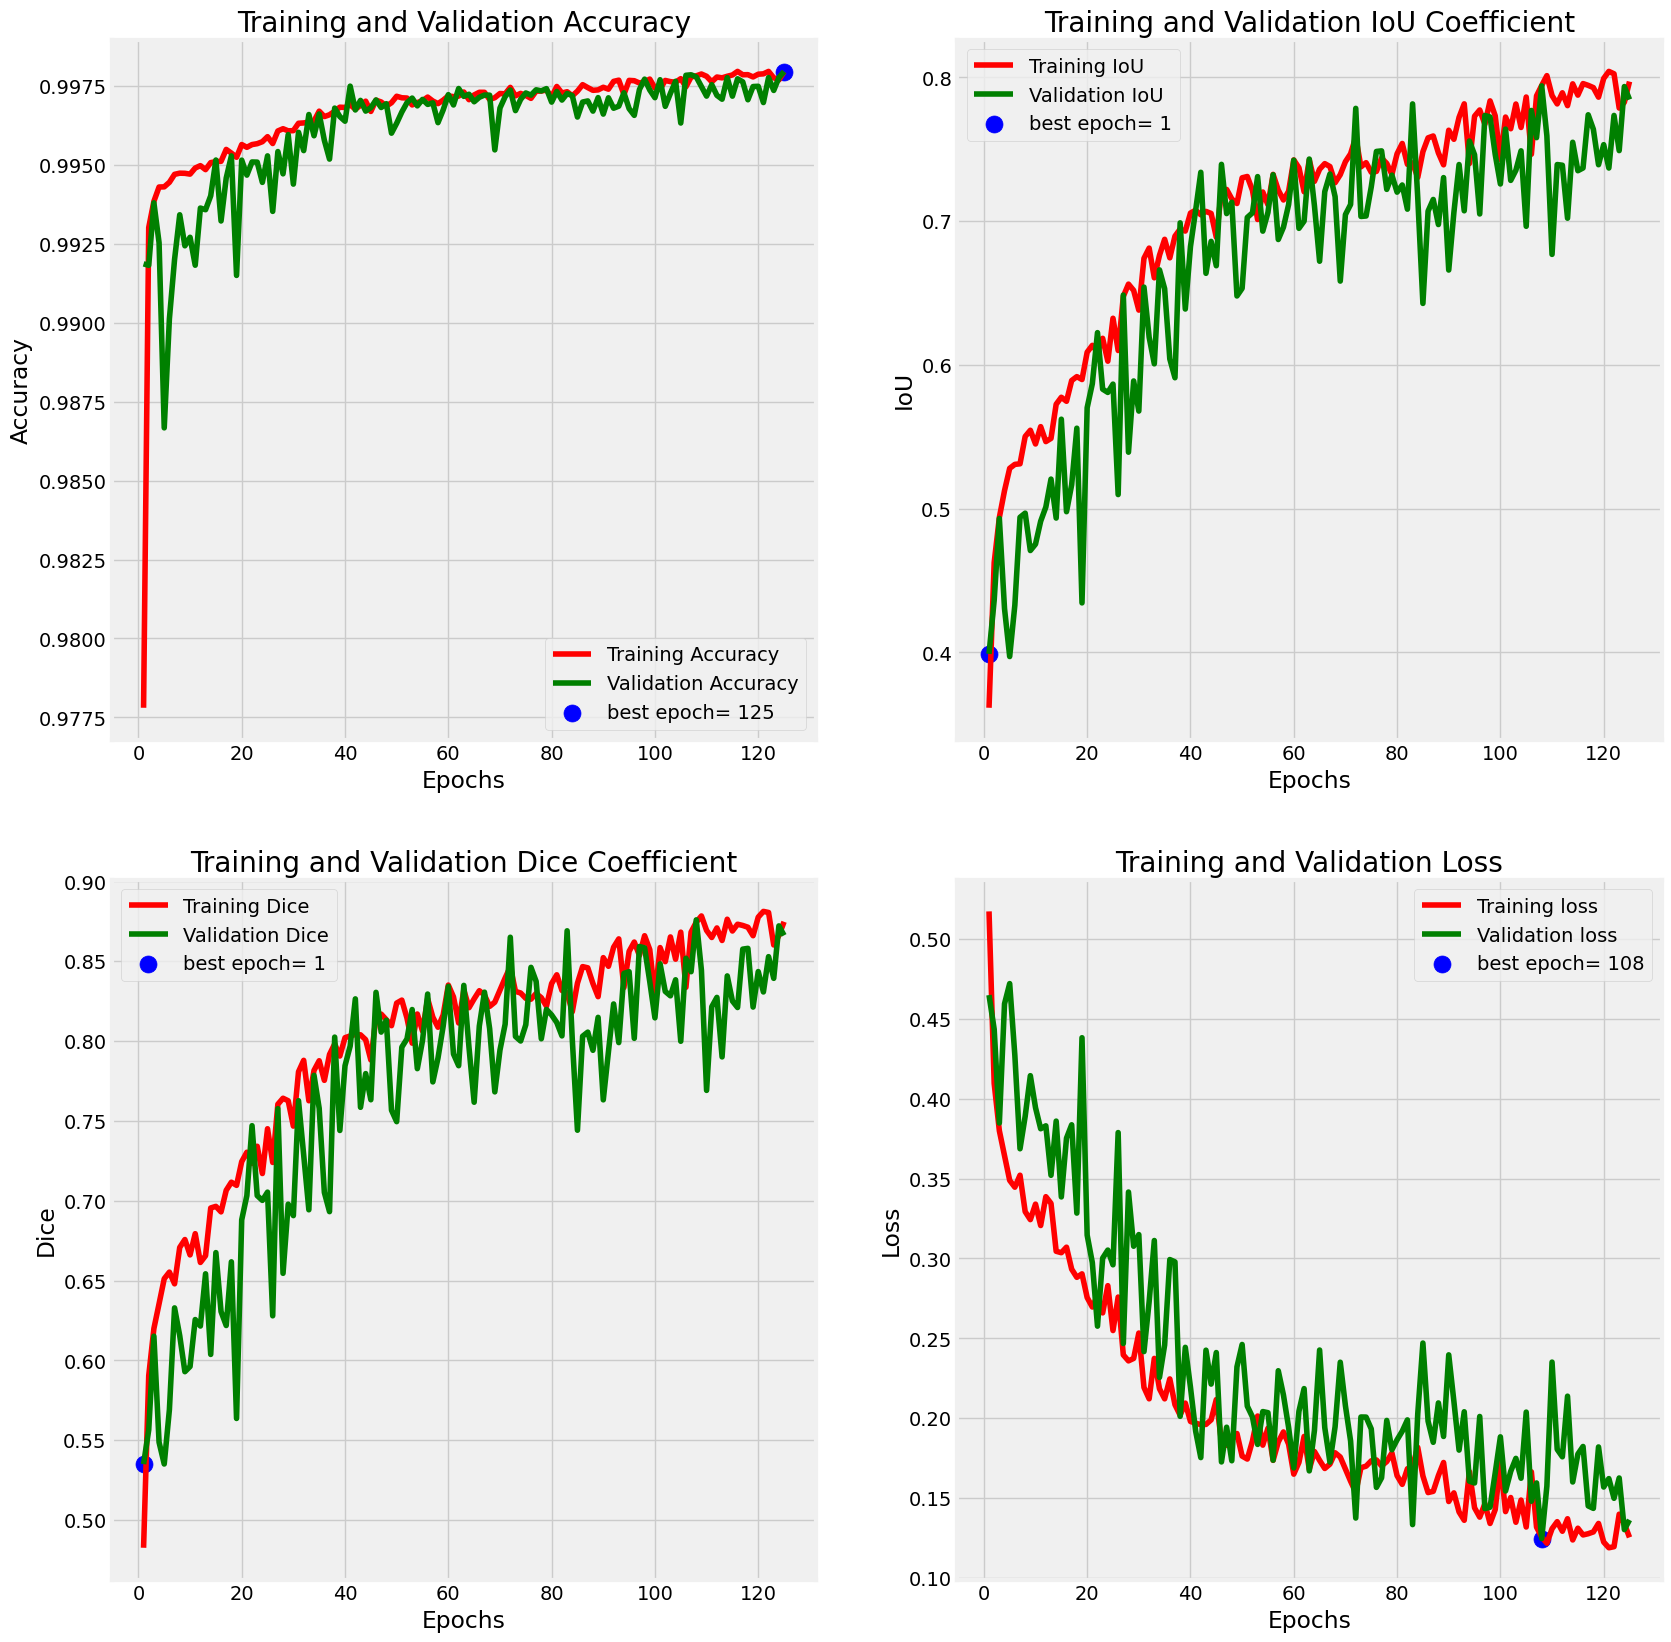

In [ ]:
plot_training(history)

In [47]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/home/anhhao/learn/ComputerVision/CK_segmentation/Unet_BrainTumor_Segmentaion/model_saved/model_UnetTCGA_v4_125-epochs.keras",
                          custom_objects={'dice_loss': dice_loss, 'iou_coef': iou_coef, 'dice_coef': dice_coef})

In [ ]:
ts_length = len(test_dir)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = loaded_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = loaded_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = loaded_model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 256ms/step - accuracy: 0.9978 - dice_coef: 0.8807 - iou_coef: 0.7988 - loss: 0.1193
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.9977 - dice_coef: 0.8717 - iou_coef: 0.7921 - loss: 0.1300
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.9976 - dice_coef: 0.8519 - iou_coef: 0.7685 - loss: 0.1494
Train Loss:  0.1107570230960846
Train Accuracy:  0.9979121088981628
Train IoU:  0.8112398982048035
Train Dice:  0.8892760872840881
--------------------
Valid Loss:  0.14233607053756714
Valid Accuracy:  0.9977342486381531
Valid IoU:  0.7832326889038086
Valid Dice:  0.8605159521102905
--------------------
Test Loss:  0.14270855486392975
Test Accuracy:  0.9976567029953003
Test IoU:  0.7828166484832764
Test Dice:  0.8591976761817932


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


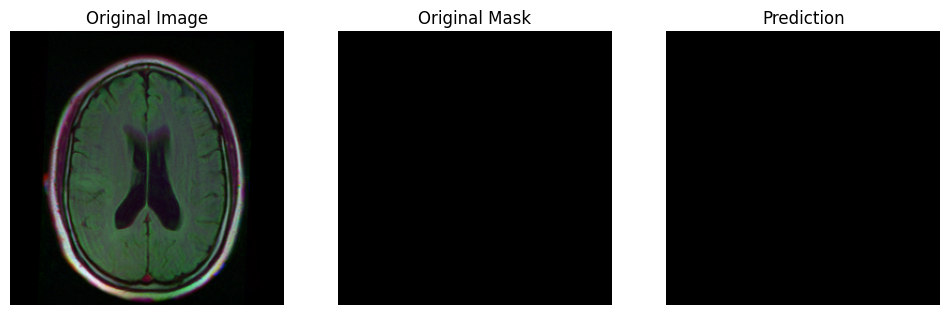

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


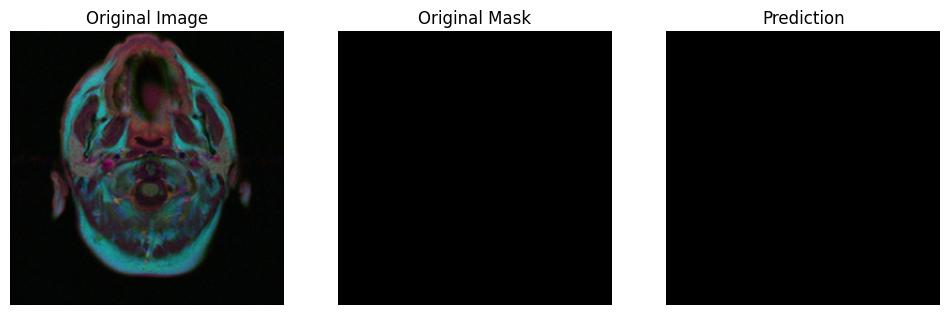

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


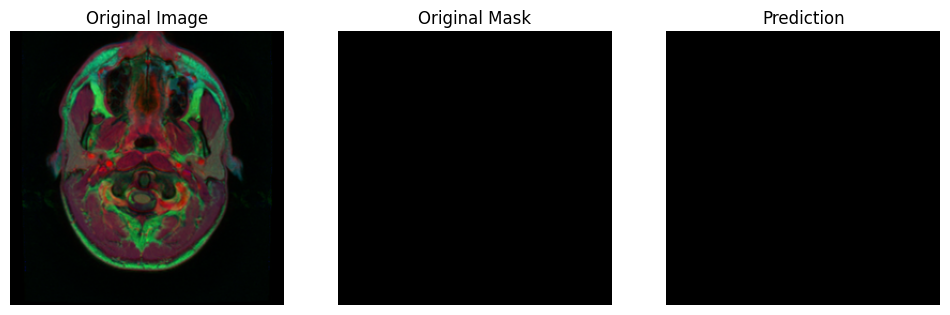

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


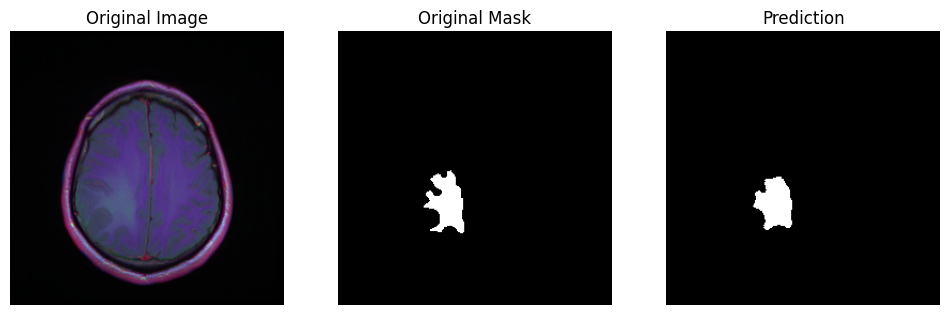

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


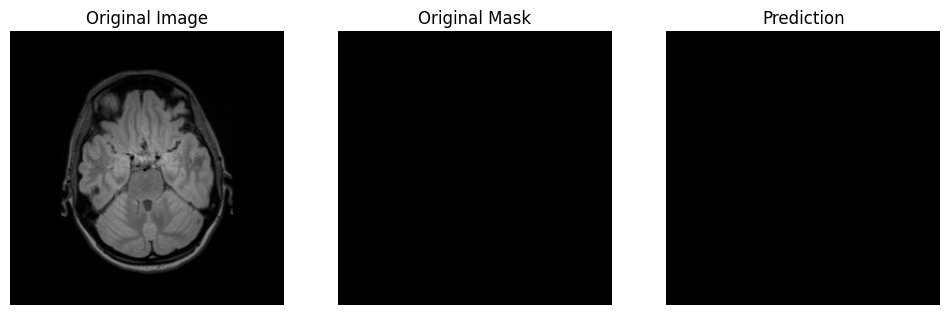

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


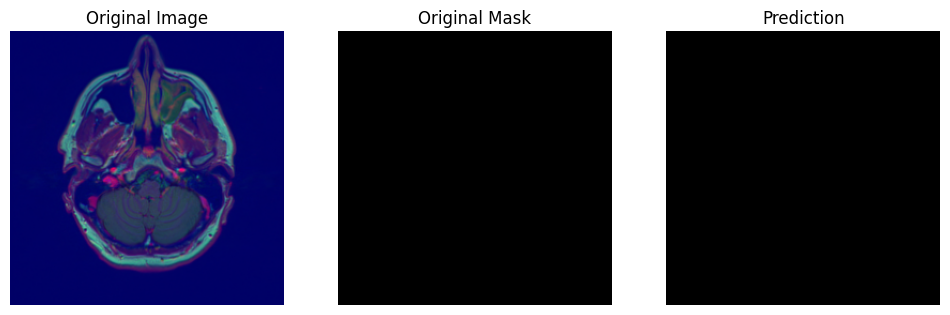

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


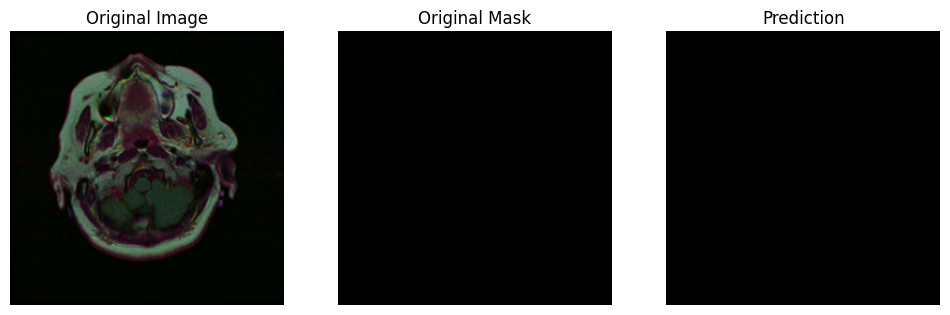

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


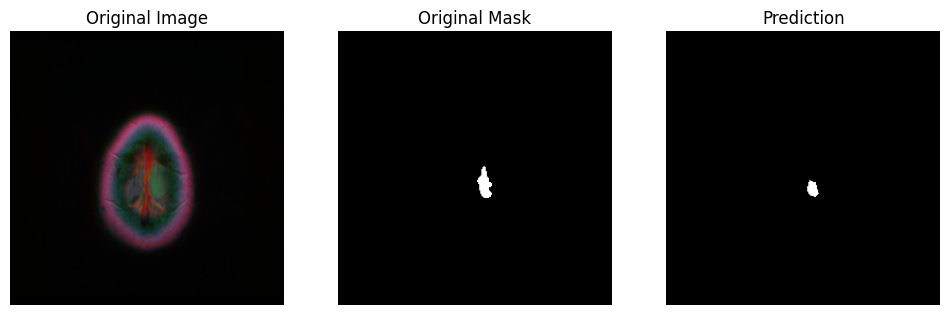

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


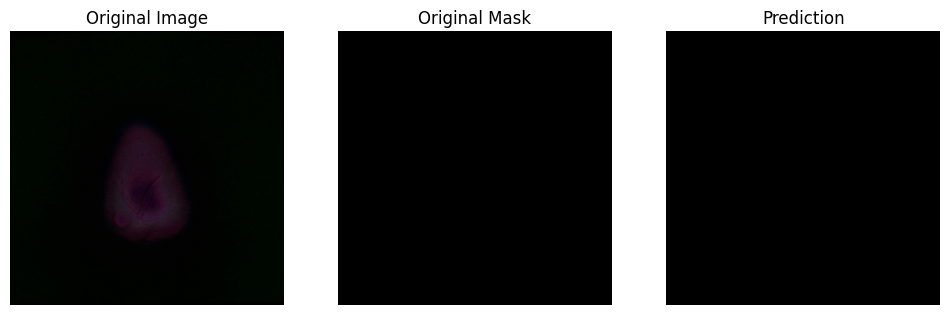

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


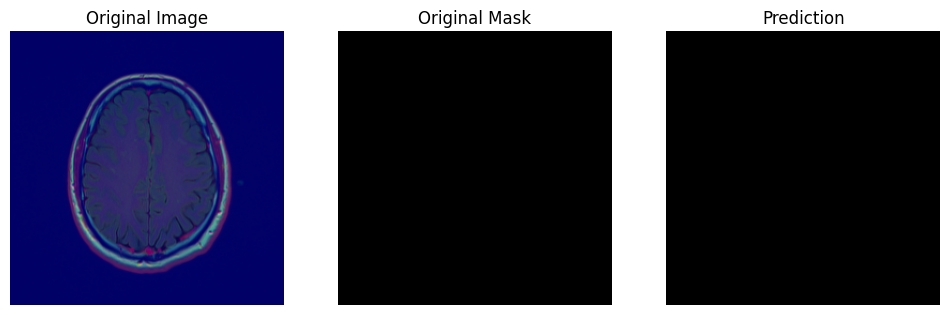

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


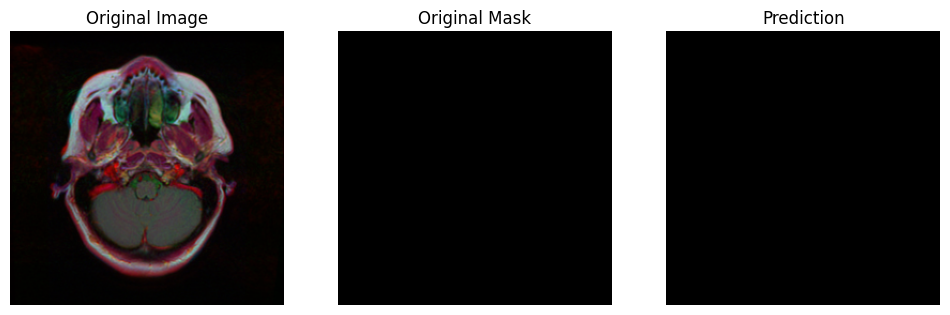

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


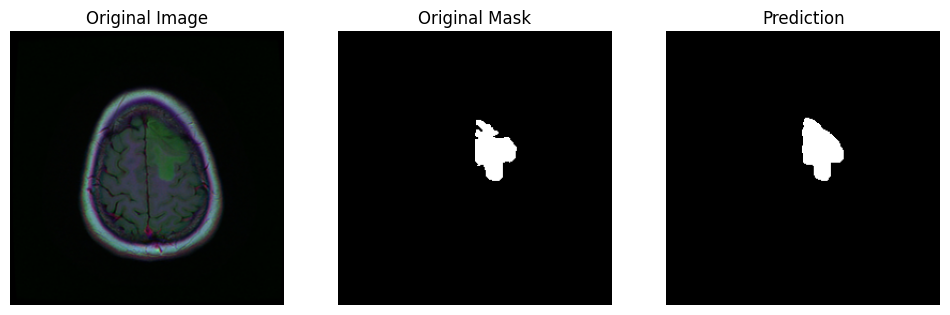

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


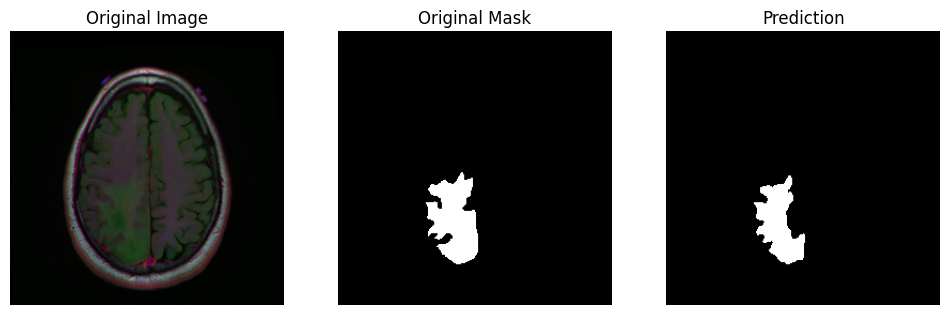

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


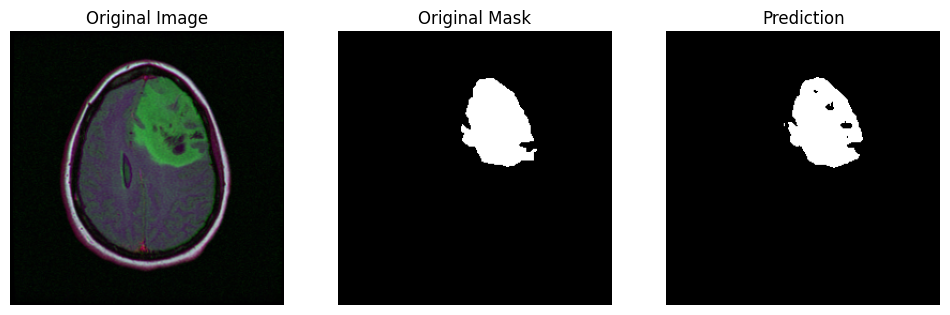

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


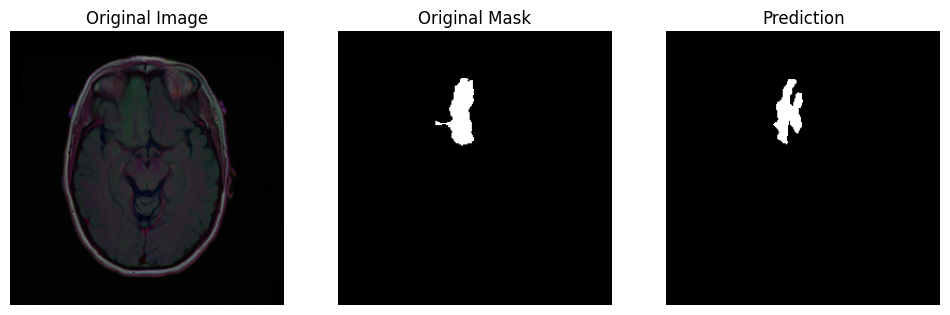

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


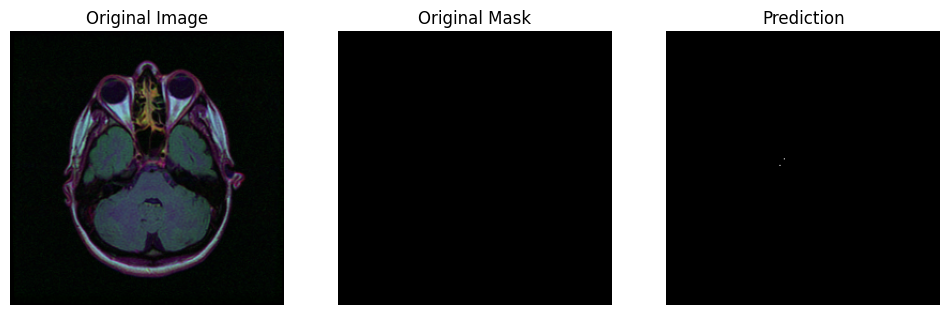

In [54]:
# Prediction
for _ in range(16):
    index = np.random.randint(1, len(test_dir.index))
    img = cv2.imread(test_dir['images'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255.
    img = img[np.newaxis, :, :, : ]

    predicted_img = loaded_model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_dir['masks'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 , cmap='gray')
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()